In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
from collections import Counter
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import transforms
from PIL import Image
import os
import numpy as np
from tqdm import tqdm

In [2]:
# 데이터셋 클래스 정의
class GunshotDataset(Dataset):
    def __init__(self, file_list):
        self.file_list = file_list

    def __len__(self):
        return len(self.file_list)

    def __getitem__(self, idx):
        file_path = os.path.join(data_dir, self.file_list[idx])  # 파일 경로 설정
        data = np.load(file_path)
        label = int(file_path.split('_')[-1].split('.')[0])  # assuming label is part of the file name
        data = torch.tensor(data, dtype=torch.float32).unsqueeze(0)  # add channel dimension
        return data, label

In [3]:
# 모델 클래스 정의
class GunshotClassifier(nn.Module):
    def __init__(self, num_classes):
        super(GunshotClassifier, self).__init__()
        self.model = models.resnet50(pretrained=True)
        self.model.conv1 = nn.Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
        self.model.fc = nn.Linear(self.model.fc.in_features, num_classes)

    def forward(self, x):
        x = self.model(x)
        return x

In [4]:
def compute_accuracy(outputs, labels):
    _, predicted = torch.max(outputs, 1)
    correct = (predicted == labels).sum().item()
    accuracy = correct / labels.size(0)
    return accuracy

In [5]:
# 데이터 디렉터리 설정 및 클래스 데이터 수 확인
data_dir = 'C:/Users/SSAFY/Desktop/augmented_combined_features'
filepaths = [os.path.join(data_dir, file) for file in os.listdir(data_dir) if file.endswith('.npy')]
labels = [file.split('_')[0] for file in filepaths]
label_counts = Counter(labels)
print(label_counts)

Counter({'C:/Users/SSAFY/Desktop/augmented': 11536})


In [6]:
import torch.nn as nn
import torchvision.models as models
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

In [7]:
# 데이터셋 생성 및 분할
dataset = GunshotDataset([os.path.basename(fp) for fp in filepaths])
train_size = int(0.9 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

# 데이터 로더 생성
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

In [8]:
# 모델 초기화
num_classes = 6
model = GunshotClassifier(num_classes)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

# 손실 함수, 옵티마이저, 스케줄러 정의
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
scheduler = StepLR(optimizer, step_size=10, gamma=0.1)

# 학습 및 평가 반복
num_epochs = 50
best_accuracy = 0.0
train_losses = []
val_accuracies = []

c:\Users\SSAFY\anaconda3\envs\sound\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\SSAFY\anaconda3\envs\sound\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [ ]:
# 모델 불러오기 (기존에 저장한 모델 파일이 있을 경우)
model_save_path = 'gunshot_classifier.pth'
if os.path.exists(model_save_path):
    model.load_state_dict(torch.load(model_save_path))
    print("Previous model loaded.")

In [9]:
for epoch in range(num_epochs):
    # 학습
    model.train()
    running_loss = 0.0
    progress_bar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}")
    
    for images, labels in progress_bar:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * images.size(0)
        progress_bar.set_postfix(loss=running_loss / ((progress_bar.n + 1) * batch_size))

    epoch_loss = running_loss / len(train_loader.dataset)
    train_losses.append(epoch_loss)

    # 검증
    model.eval()
    correct = 0
    total = 0
    
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    
    accuracy = 100 * correct / total
    val_accuracies.append(accuracy)

    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.4f}, Accuracy: {accuracy:.2f}%')

    if accuracy > best_accuracy:
        best_accuracy = accuracy
        torch.save(model.state_dict(), 'gunshot_classifier.pth')

    scheduler.step()  # 학습률 스케줄러 업데이트

Epoch 1/50: 100%|██████████| 325/325 [00:32<00:00, 10.12it/s, loss=0.664]


Epoch [1/50], Loss: 0.6631, Accuracy: 61.96%


Epoch 2/50: 100%|██████████| 325/325 [00:29<00:00, 10.95it/s, loss=0.599]


Epoch [2/50], Loss: 0.5986, Accuracy: 64.12%


Epoch 3/50: 100%|██████████| 325/325 [00:32<00:00, 10.13it/s, loss=0.564]


Epoch [3/50], Loss: 0.5654, Accuracy: 58.41%


Epoch 4/50: 100%|██████████| 325/325 [00:32<00:00, 10.12it/s, loss=0.552]


Epoch [4/50], Loss: 0.5532, Accuracy: 65.34%


Epoch 5/50: 100%|██████████| 325/325 [00:32<00:00, 10.07it/s, loss=0.541]


Epoch [5/50], Loss: 0.5418, Accuracy: 65.42%


Epoch 6/50: 100%|██████████| 325/325 [00:32<00:00, 10.03it/s, loss=0.539]


Epoch [6/50], Loss: 0.5400, Accuracy: 66.90%


Epoch 7/50: 100%|██████████| 325/325 [00:32<00:00,  9.98it/s, loss=0.535]


Epoch [7/50], Loss: 0.5338, Accuracy: 68.89%


Epoch 8/50: 100%|██████████| 325/325 [00:32<00:00, 10.01it/s, loss=0.532]


Epoch [8/50], Loss: 0.5327, Accuracy: 65.42%


Epoch 9/50: 100%|██████████| 325/325 [00:32<00:00, 10.01it/s, loss=0.538]


Epoch [9/50], Loss: 0.5392, Accuracy: 68.54%


Epoch 10/50: 100%|██████████| 325/325 [00:32<00:00, 10.00it/s, loss=0.506]


Epoch [10/50], Loss: 0.5073, Accuracy: 65.42%


Epoch 11/50: 100%|██████████| 325/325 [00:32<00:00, 10.01it/s, loss=0.322]


Epoch [11/50], Loss: 0.3230, Accuracy: 92.98%


Epoch 12/50: 100%|██████████| 325/325 [00:32<00:00, 10.01it/s, loss=0.153]


Epoch [12/50], Loss: 0.1524, Accuracy: 92.72%


Epoch 13/50: 100%|██████████| 325/325 [00:32<00:00, 10.01it/s, loss=0.142]


Epoch [13/50], Loss: 0.1420, Accuracy: 47.40%


Epoch 14/50: 100%|██████████| 325/325 [00:32<00:00, 10.04it/s, loss=0.156]


Epoch [14/50], Loss: 0.1558, Accuracy: 92.37%


Epoch 15/50: 100%|██████████| 325/325 [00:32<00:00, 10.02it/s, loss=0.137]


Epoch [15/50], Loss: 0.1364, Accuracy: 91.85%


Epoch 16/50: 100%|██████████| 325/325 [00:32<00:00, 10.03it/s, loss=0.133]


Epoch [16/50], Loss: 0.1332, Accuracy: 93.07%


Epoch 17/50: 100%|██████████| 325/325 [00:32<00:00, 10.00it/s, loss=0.14] 


Epoch [17/50], Loss: 0.1407, Accuracy: 91.85%


Epoch 18/50: 100%|██████████| 325/325 [00:32<00:00,  9.98it/s, loss=0.133]


Epoch [18/50], Loss: 0.1329, Accuracy: 79.81%


Epoch 19/50: 100%|██████████| 325/325 [00:32<00:00, 10.01it/s, loss=0.138]


Epoch [19/50], Loss: 0.1381, Accuracy: 92.63%


Epoch 20/50: 100%|██████████| 325/325 [00:32<00:00,  9.95it/s, loss=0.132]


Epoch [20/50], Loss: 0.1324, Accuracy: 92.72%


Epoch 21/50: 100%|██████████| 325/325 [00:32<00:00,  9.99it/s, loss=0.137]


Epoch [21/50], Loss: 0.1373, Accuracy: 92.72%


Epoch 22/50: 100%|██████████| 325/325 [00:32<00:00, 10.01it/s, loss=0.134]


Epoch [22/50], Loss: 0.1345, Accuracy: 91.85%


Epoch 23/50: 100%|██████████| 325/325 [00:32<00:00, 10.00it/s, loss=0.133]


Epoch [23/50], Loss: 0.1333, Accuracy: 91.94%


Epoch 24/50: 100%|██████████| 325/325 [00:32<00:00,  9.98it/s, loss=0.134]


Epoch [24/50], Loss: 0.1342, Accuracy: 68.98%


Epoch 25/50: 100%|██████████| 325/325 [00:32<00:00,  9.97it/s, loss=0.134]


Epoch [25/50], Loss: 0.1340, Accuracy: 91.85%


Epoch 26/50: 100%|██████████| 325/325 [00:32<00:00,  9.97it/s, loss=0.135]


Epoch [26/50], Loss: 0.1355, Accuracy: 92.63%


Epoch 27/50: 100%|██████████| 325/325 [00:32<00:00, 10.01it/s, loss=0.134]


Epoch [27/50], Loss: 0.1337, Accuracy: 91.94%


Epoch 28/50: 100%|██████████| 325/325 [00:32<00:00, 10.01it/s, loss=0.133]


Epoch [28/50], Loss: 0.1331, Accuracy: 65.25%


Epoch 29/50: 100%|██████████| 325/325 [00:32<00:00,  9.97it/s, loss=0.133]


Epoch [29/50], Loss: 0.1332, Accuracy: 92.29%


Epoch 30/50: 100%|██████████| 325/325 [00:32<00:00,  9.98it/s, loss=0.133]


Epoch [30/50], Loss: 0.1334, Accuracy: 91.85%


Epoch 31/50: 100%|██████████| 325/325 [00:32<00:00,  9.96it/s, loss=0.133]


Epoch [31/50], Loss: 0.1336, Accuracy: 91.85%


Epoch 32/50: 100%|██████████| 325/325 [00:32<00:00, 10.00it/s, loss=0.131]


Epoch [32/50], Loss: 0.1315, Accuracy: 91.42%


Epoch 33/50: 100%|██████████| 325/325 [00:32<00:00,  9.94it/s, loss=0.132]


Epoch [33/50], Loss: 0.1323, Accuracy: 91.94%


Epoch 34/50: 100%|██████████| 325/325 [00:32<00:00,  9.99it/s, loss=0.131]


Epoch [34/50], Loss: 0.1316, Accuracy: 76.08%


Epoch 35/50: 100%|██████████| 325/325 [00:32<00:00,  9.98it/s, loss=0.134]


Epoch [35/50], Loss: 0.1346, Accuracy: 91.85%


Epoch 36/50: 100%|██████████| 325/325 [00:32<00:00,  9.98it/s, loss=0.135]


Epoch [36/50], Loss: 0.1354, Accuracy: 91.85%


Epoch 37/50: 100%|██████████| 325/325 [00:32<00:00, 10.03it/s, loss=0.133]


Epoch [37/50], Loss: 0.1334, Accuracy: 91.85%


Epoch 38/50: 100%|██████████| 325/325 [00:32<00:00, 10.01it/s, loss=0.134]


Epoch [38/50], Loss: 0.1335, Accuracy: 91.94%


Epoch 39/50: 100%|██████████| 325/325 [00:32<00:00,  9.97it/s, loss=0.133]


Epoch [39/50], Loss: 0.1331, Accuracy: 91.85%


Epoch 40/50: 100%|██████████| 325/325 [00:32<00:00, 10.00it/s, loss=0.133]


Epoch [40/50], Loss: 0.1329, Accuracy: 91.85%


Epoch 41/50: 100%|██████████| 325/325 [00:32<00:00,  9.98it/s, loss=0.135]


Epoch [41/50], Loss: 0.1351, Accuracy: 91.85%


Epoch 42/50: 100%|██████████| 325/325 [00:32<00:00, 10.00it/s, loss=0.133]


Epoch [42/50], Loss: 0.1331, Accuracy: 65.25%


Epoch 43/50: 100%|██████████| 325/325 [00:32<00:00, 10.03it/s, loss=0.131]


Epoch [43/50], Loss: 0.1312, Accuracy: 91.94%


Epoch 44/50: 100%|██████████| 325/325 [00:32<00:00, 10.01it/s, loss=0.132]


Epoch [44/50], Loss: 0.1322, Accuracy: 91.85%


Epoch 45/50: 100%|██████████| 325/325 [00:32<00:00, 10.01it/s, loss=0.133]


Epoch [45/50], Loss: 0.1323, Accuracy: 91.94%


Epoch 46/50: 100%|██████████| 325/325 [00:32<00:00, 10.01it/s, loss=0.133]


Epoch [46/50], Loss: 0.1331, Accuracy: 91.85%


Epoch 47/50: 100%|██████████| 325/325 [00:32<00:00,  9.99it/s, loss=0.134]


Epoch [47/50], Loss: 0.1340, Accuracy: 91.94%


Epoch 48/50: 100%|██████████| 325/325 [00:32<00:00, 10.00it/s, loss=0.133]


Epoch [48/50], Loss: 0.1334, Accuracy: 91.85%


Epoch 49/50: 100%|██████████| 325/325 [00:32<00:00,  9.98it/s, loss=0.131]


Epoch [49/50], Loss: 0.1309, Accuracy: 91.94%


Epoch 50/50: 100%|██████████| 325/325 [00:32<00:00,  9.99it/s, loss=0.134]


Epoch [50/50], Loss: 0.1335, Accuracy: 91.85%


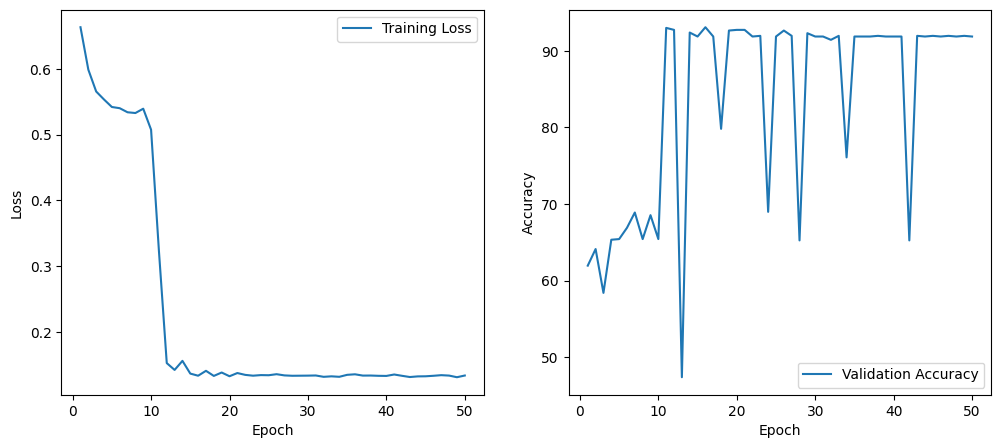

In [10]:
# 학습 손실 및 검증 정확도 시각화
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(range(1, num_epochs + 1), train_losses, label='Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(range(1, num_epochs + 1), val_accuracies, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

In [12]:
# 모델 평가 및 혼동 행렬 생성
model.load_state_dict(torch.load('gunshot_classifier.pth'))
model.eval()

all_preds = []
all_labels = []

with torch.no_grad():
    for images, labels in val_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=sorted(dataset.classes), yticklabels=sorted(dataset.classes))
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

AttributeError: 'GunshotDataset' object has no attribute 'classes'

<Figure size 1000x800 with 0 Axes>